In [1]:
import requests
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
import os
import random
import plotly.express as px
warnings.filterwarnings('ignore')

# Range of years
start_year = 2013
end_year = 2022
current_year = 2023

# Set environment variables for reproducibility
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# Load the dataframe
with open('data.pickle','rb') as file:
    data = pickle.load(file)

data.shape

(5372, 311)

In [3]:
# for i, model in enumerate(xgb_model):
#     with open(f'xgb_model_{i}.pkl', 'wb') as f:
#         pickle.dump(model, f)

xgb_model = []
for i in range(10):
    with open(f'xgb_model_{i}.pkl', 'rb') as f:
        temp_xgb_model = pickle.load(f)
        xgb_model.append(temp_xgb_model)
xgb_model

In [4]:
# XGBoost model config
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess


param = {} 

# Testing:
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run (from 0.05)
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10 (from 3)
param['min_child_weight'] = 40 
param['gamma'] = 10
param['max_depth'] =  3
# param['silent'] = 1
repeat_cv = 3 # recommend 10 (from 3)


# Submission:
# param['eval_metric'] =  'mae'
# param['booster'] = 'gbtree'
# param['eta'] = 0.02 #change to ~0.02 for final run (from 0.05)
# param['subsample'] = 0.35
# param['colsample_bytree'] = 0.7
# param['num_parallel_tree'] = 10 #recommend 10 (from 3)
# param['min_child_weight'] = 40 
# param['gamma'] = 10
# param['max_depth'] =  3
# # param['silent'] = 1
# repeat_cv = 10 # recommend 10 (from 3)

In [5]:
def train_xgboost(dtrain):
    xgb_cv = []

    for i in range(repeat_cv): 
        print(f"Fold repeater {i}")
        xgb_cv.append(
            xgb.cv(
              params = param,
              dtrain = dtrain,
              obj = cauchyobj,
              num_boost_round = 3000,
              folds = KFold(n_splits = 5, shuffle = True, random_state = i),
              early_stopping_rounds = 25,
              verbose_eval = 50
            )
        )

    iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
    val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
    print(iteration_counts, val_mae, "\n\n")
    return xgb_cv, iteration_counts

def oof_predictions(X, y, iteration_counts):
    oof_preds = []
    for i in range(repeat_cv):
        print(f"Fold repeater {i}")
        preds = y.copy()
        kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
        for train_index, val_index in kfold.split(X,y):
            dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
            dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
            model = xgb.train(
                  params = param,
                  dtrain = dtrain_i,
                  num_boost_round = iteration_counts[i],
                  verbose_eval = 50
            )
            preds[val_index] = model.predict(dval_i)
        oof_preds.append(np.clip(preds,-30,30))
    print("MAE: ", mean_absolute_error(sum(oof_preds)/len(oof_preds), y), "\n\n")
    return oof_preds

def train_final_model(dtrain, iteration_counts):
    xgboost_models = []
    for i in range(repeat_cv):
        print(f"Fold repeater {i}")
        xgboost_models.append(
            xgb.train(
              params = param,
              dtrain = dtrain,
              num_boost_round = int(iteration_counts[i] * 1.05),
              verbose_eval = 50
            )
        )
    return xgboost_models

def prediction(xgboost_models, dmatrix):
    preds = []
    for i in range(repeat_cv):
        preds.append(np.clip(xgboost_models[i].predict(dmatrix),-300,300))
    return sum(preds) / len(preds)

# Final data preprocessing

In [8]:
excluded = ['id','year','week','home_team','away_team','margin','home_points','away_points']
categorical_features = ['neutral_site', 'home_conference','away_conference']
cont_features = [c for c in data.columns.to_list() if c not in categorical_features and c not in excluded]

In [9]:
test_data = data.query("year >= 2022")
train_data = data.query("year < 2022")
# test_data = data.query("year >= 2022 and week >= 3")
# train_data = data.query("year < 2022 and week >= 3")

vegas_rmse = mean_squared_error(test_data['spread'], test_data['margin']) ** 0.5
vegas_mae = mean_absolute_error(test_data['spread'], test_data['margin'])

X_train = train_data.drop(columns=excluded)
X_test = test_data.drop(columns=excluded)

y_train = train_data['margin'].values
y_test = test_data['margin'].values

quantitative_features = [item for item in list(X_train.columns) if item not in categorical_features]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_features),  # One-hot encode categorical features
        ('num', StandardScaler(), quantitative_features),  # Standardize numerical features
    ],
    remainder='passthrough'  # Pass through any features not explicitly transformed
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
dtrain = xgb.DMatrix(X_train_scaled, label = y_train)
dtest = xgb.DMatrix(X_test_scaled, label = y_test)

In [10]:
xgb_cv, iteration_counts = train_xgboost(dtrain)
oof_preds = oof_predictions(X_train_scaled, y_train, iteration_counts)
xgb_model = train_final_model(dtrain, iteration_counts)

XGBprediction = prediction(xgb_model, dtest)
print("RMSE: ", mean_squared_error(y_test, XGBprediction) ** 0.5, '  MAE: ", mean_absolute_error(y_test, XGBprediction))

Fold repeater 0
[0]	train-mae:17.04491+0.11134	test-mae:17.06063+0.44327
[50]	train-mae:12.20497+0.08289	test-mae:12.72942+0.30085
[100]	train-mae:11.69248+0.08695	test-mae:12.67087+0.29834
[110]	train-mae:11.61282+0.08706	test-mae:12.67100+0.28830
Fold repeater 1
[0]	train-mae:17.05738+0.15441	test-mae:17.06974+0.62948
[50]	train-mae:12.20524+0.05594	test-mae:12.75692+0.28633
[100]	train-mae:11.69498+0.05973	test-mae:12.66431+0.25190
[115]	train-mae:11.56850+0.06232	test-mae:12.66832+0.25563
Fold repeater 2
[0]	train-mae:17.05541+0.06116	test-mae:17.07231+0.27077
[50]	train-mae:12.21178+0.08179	test-mae:12.71482+0.31756
[100]	train-mae:11.69557+0.07130	test-mae:12.65424+0.31146
[132]	train-mae:11.44249+0.07144	test-mae:12.66157+0.31384
[85, 90, 108] [12.664752544895295, 12.663577090553058, 12.651185437312689] 


Fold repeater 0
Fold repeater 1
Fold repeater 2
MAE:  12.673763440860215 


Fold repeater 0
Fold repeater 1
Fold repeater 2
15.43997919392271 12.1873414578578


In [11]:
# Train the model with the difference of home and away features for each stat
paired_columns = []
nonpaired_columns = ['neutral_site', 'spread', 'home_conference', 'away_conference', 'home_team_performance_at_home_past_1_years', 'away_team_performance_at_away_past_1_years', 'home_team_performance_at_home_past_2_years', 'away_team_performance_at_away_past_2_years', 'home_team_performance_at_home_past_5_years', 'away_team_performance_at_away_past_5_years', 'home_vs_away_teams_performances_past_1_years', 'home_vs_away_teams_performances_past_2_years', 'home_vs_away_teams_performances_past_5_years']

for column in list(X_train.columns):
    if column in nonpaired_columns:
        continue
    if column.startswith("home_"):
        element = column[len("home_"):]
        if  element not in paired_columns:
            paired_columns.append(element)
    elif column.startswith("away_"):
        element = column[len("away_"):]
        if  element not in paired_columns:
            paired_columns.append(element)
    else:
        nonpaired_columns.append(column)
        
paired_X_train = X_train[nonpaired_columns].copy()
paired_X_test = X_test[nonpaired_columns].copy()
combined_X_train = X_train.copy()
combined_X_test = X_test.copy()

for feature in paired_columns:
    home_col = f'home_{feature}'
    away_col = f'away_{feature}'
    diff_col = f'diff_{feature}'
    paired_X_train[diff_col] = X_train[home_col] - X_train[away_col]
    paired_X_test[diff_col] = X_test[home_col] - X_test[away_col]
    combined_X_train[diff_col] = X_train[home_col] - X_train[away_col]
    combined_X_test[diff_col] = X_test[home_col] - X_test[away_col]
    
paired_quantitative_features = [item for item in list(paired_X_train.columns) if item not in categorical_features]
combined_quantitative_features = [item for item in list(paired_X_train.columns) if item not in categorical_features]

paired_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_features),  # One-hot encode categorical features
        ('num', StandardScaler(), paired_quantitative_features),  # Standardize numerical features
    ],
    remainder='passthrough'  # Pass through any features not explicitly transformed
)
combined_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_features),  # One-hot encode categorical features
        ('num', StandardScaler(), combined_quantitative_features),  # Standardize numerical features
    ],
    remainder='passthrough'  # Pass through any features not explicitly transformed
)

paired_X_train_scaled = paired_preprocessor.fit_transform(paired_X_train)
paired_X_test_scaled = paired_preprocessor.transform(paired_X_test)
combined_X_train_scaled = combined_preprocessor.fit_transform(combined_X_train)
combined_X_test_scaled = combined_preprocessor.transform(combined_X_test)

paired_dtrain = xgb.DMatrix(paired_X_train_scaled, label = y_train)
paired_dtest = xgb.DMatrix(paired_X_test_scaled, label = y_test)
combined_dtrain = xgb.DMatrix(combined_X_train_scaled, label = y_train)
combined_dtest = xgb.DMatrix(combined_X_test_scaled, label = y_test)

In [18]:
paired_xgb_cv, paired_iteration_counts = train_xgboost(paired_dtrain)
oof_preds = oof_predictions(paired_X_train_scaled, y_train, paired_iteration_counts)
paired_xgb_model = train_final_model(paired_dtrain, paired_iteration_counts)

paired_xgb_prediction = prediction(paired_xgb_model, paired_dtest)
print("RMSE: ", mean_squared_error(y_test, paired_xgb_prediction) ** 0.5,  "MAE: ", mean_absolute_error(y_test, paired_xgb_prediction))

Fold repeater 0
[0]	train-mae:16.92039+0.10750	test-mae:16.92944+0.44725
[50]	train-mae:12.22946+0.07581	test-mae:12.66856+0.29492
[100]	train-mae:11.78545+0.07579	test-mae:12.62751+0.30503
[101]	train-mae:11.77807+0.07465	test-mae:12.62889+0.30518
Fold repeater 1
[0]	train-mae:16.92418+0.15229	test-mae:16.93146+0.63005
[50]	train-mae:12.22715+0.06079	test-mae:12.70802+0.28303
[100]	train-mae:11.78260+0.06330	test-mae:12.66131+0.25306
[115]	train-mae:11.67500+0.06746	test-mae:12.66586+0.25189
Fold repeater 2
[0]	train-mae:16.92013+0.05821	test-mae:16.92635+0.26224
[50]	train-mae:12.23212+0.07676	test-mae:12.70100+0.32555
[100]	train-mae:11.78096+0.06396	test-mae:12.65129+0.32118
[110]	train-mae:11.70994+0.06017	test-mae:12.66221+0.32345
[76, 90, 85] [12.616417559385301, 12.656976708994119, 12.647527934646094] 


Fold repeater 0
Fold repeater 1
Fold repeater 2
MAE:  12.676200716845878 


Fold repeater 0
Fold repeater 1
Fold repeater 2
RMSE:  15.38215857072253 MAE:  12.142550613084897


In [19]:
combined_xgb_cv, combined_iteration_counts = train_xgboost(combined_dtrain)
oof_preds = oof_predictions(combined_X_train_scaled, y_train, combined_iteration_counts)
combined_xgb_model = train_final_model(combined_dtrain, combined_iteration_counts)

combined_xgb_prediction = prediction(combined_xgb_model, combined_dtest)
print("RMSE: ", mean_squared_error(y_test, combined_xgb_prediction) ** 0.5,  "MAE: ", mean_absolute_error(y_test, combined_xgb_prediction))

Fold repeater 0
[0]	train-mae:16.95423+0.10825	test-mae:16.96706+0.44804
[50]	train-mae:12.16261+0.08268	test-mae:12.69525+0.31449
[100]	train-mae:11.64750+0.08156	test-mae:12.64547+0.31493
[110]	train-mae:11.56292+0.07931	test-mae:12.64330+0.31864
Fold repeater 1
[0]	train-mae:16.96049+0.15080	test-mae:16.97320+0.62680
[50]	train-mae:12.15254+0.06256	test-mae:12.71664+0.27937
[100]	train-mae:11.63148+0.06264	test-mae:12.65373+0.23836
[108]	train-mae:11.55543+0.06278	test-mae:12.65161+0.23832
Fold repeater 2
[0]	train-mae:16.95833+0.05814	test-mae:16.96827+0.26949
[50]	train-mae:12.16116+0.07714	test-mae:12.70770+0.35013
[100]	train-mae:11.63039+0.08285	test-mae:12.64925+0.32518
[123]	train-mae:11.43855+0.09023	test-mae:12.65365+0.31614
[85, 84, 99] [12.635561412021678, 12.646657985102745, 12.649062271605256] 


Fold repeater 0
Fold repeater 1
Fold repeater 2
MAE:  12.672544802867382 


Fold repeater 0
Fold repeater 1
Fold repeater 2
RMSE:  15.464552252717866 MAE:  12.20970734309178


# Neural Network Training

In [97]:
def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
        
def train_neural_network(X_train, y_train, model_name="NNmodel.h5"):
    # Set environment variables for reproducibility
    os.environ['PYTHONHASHSEED'] = str(42)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    lr_scheduler = LearningRateScheduler(schedule)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train_NN = X_train.astype('float32')
    y_train_NN = y_train.astype('float32')
    X_cv_NN = X_cv.astype('float32')
    y_cv_NN = y_cv.astype('float32')

    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    # Build the neural network model for regression
    sequentialModel = Sequential([
        Dense(512, input_dim=X_train_NN.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    # Compile the model
    sequentialModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    # Train the model
    history = sequentialModel.fit(X_train_NN, y_train_NN, epochs=30, batch_size=32, validation_data=(X_cv_NN, y_cv_NN), callbacks=[checkpoint, lr_scheduler], verbose=1)
    neural_network_model = load_model(model_name)

    # Evaluate the model on the validation set
    predictions = neural_network_model.predict(X_cv_NN).reshape(-1)

    # Find the epoch with the best validation loss
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    print(f"\nBest epoch: {best_epoch}")
    
    # Evaluate the model's performance on the validation set
    print(f"RMSE of Neural Network on CV Data: {mean_squared_error(y_cv_NN, predictions)**0.5}")
    print(f"MAE of Neural Network on CV Data: {mean_absolute_error(y_cv_NN, predictions)}")
    
    # Plot the learning curve
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return neural_network_model

Epoch 1/30
106/117 [==========================>...] - ETA: 0s - loss: 441.5900 - mean_absolute_error: 16.4911
Epoch 1: val_loss improved from inf to 400.16162, saving model to NNmodel.h5
117/117 [==============================] - 3s 7ms/step - loss: 432.8194 - mean_absolute_error: 16.3151 - val_loss: 400.1616 - val_mean_absolute_error: 15.7402 - lr: 0.0010
Epoch 2/30
109/117 [==========================>...] - ETA: 0s - loss: 351.8425 - mean_absolute_error: 14.7478
Epoch 2: val_loss improved from 400.16162 to 315.11823, saving model to NNmodel.h5
117/117 [==============================] - 1s 5ms/step - loss: 352.4632 - mean_absolute_error: 14.7440 - val_loss: 315.1182 - val_mean_absolute_error: 14.0932 - lr: 0.0010
Epoch 3/30
109/117 [==========================>...] - ETA: 0s - loss: 318.2120 - mean_absolute_error: 14.1394
Epoch 3: val_loss improved from 315.11823 to 290.46823, saving model to NNmodel.h5
117/117 [==============================] - 1s 5ms/step - loss: 314.8217 - mean_abso

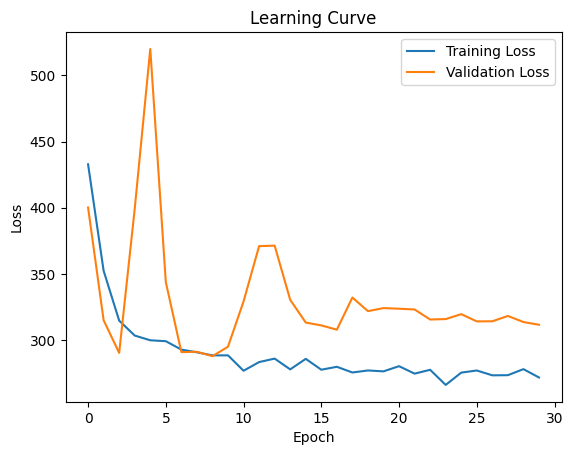

In [98]:
NNmodel = train_neural_network(combined_X_train_scaled, y_train, model_name="NNmodel.h5")

In [103]:
# Average of the three models:
# XGBmodel = xgb.XGBRegressor()
# XGBmodel.load_model("XGBmodel.json")
# NNmodel = load_model('NNmodel.h5')

class EnsembleModel:
    def __init__(self, xgb_model, nn_model):
        self.xgb_model = xgb_model
        self.nn_model = nn_model

    def predict(self, X):
        xgb_prediction = prediction(self.xgb_model, xgb.DMatrix(X))
        nn_prediction = self.nn_model.predict(X.astype('float32')).reshape(-1)
        return (xgb_prediction + nn_prediction) / 2

model = EnsembleModel(xgb_model=xgb_model, nn_model=NNmodel)

# Data Visualization

In [106]:
# model_names = ['Vegas Consensus Spread', 'XGBoost Regressor', 'Neural Network', 'Ensemble Model']
# XGBprediction = prediction(xgb_model, xgb.DMatrix(X_test_scaled))
# NNprediction = NNmodel.predict(X_test_scaled.astype('float32')).reshape(-1)
# averagePrediction = model.predict(X_test_scaled)

# rmse_values = [vegas_rmse,
#               mean_squared_error(y_test, XGBprediction) ** 0.5,
#               mean_squared_error(y_test, NNprediction) ** 0.5,
#               mean_squared_error(y_test, averagePrediction) ** 0.5]
# mae_values = [vegas_mae,
#               mean_absolute_error(y_test, XGBprediction),
#               mean_absolute_error(y_test, NNprediction),
#               mean_absolute_error(y_test, averagePrediction)]
# colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightpink']

# # Create a bar chart
# plt.figure(figsize=(12, 5))
# bars = plt.bar(model_names, rmse_values, color=colors)
# plt.ylabel('Root Mean Squared Error (RMSE)')
# plt.title('Comparison of RMSE between Vegas Consensus Spread and My Models')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.3)

# # Add more space between the top of the bars and the outline of the chart
# extra_space = 2 # Adjust this value to control the space
# plt.ylim(top=max(rmse_values) + extra_space)

# # Display the MAE values on top of the bars with a little offset
# for bar, mae in zip(bars, rmse_values):
#     plt.text(bar.get_x() + bar.get_width() / 2, mae + 0.005, str(round(mae, 4)),
#              ha='center', va='bottom', fontsize=12)

# plt.tight_layout()
# plt.show()


# # Create a bar chart
# plt.figure(figsize=(12, 5))
# bars = plt.bar(model_names, mae_values, color=colors)
# plt.ylabel('Mean Absolute Error (MAE)')
# plt.title('Comparison of MAE between Vegas Consensus Spread and My Models')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.3)
# plt.ylim(top=max(mae_values) + extra_space)

# # Display the MAE values on top of the bars with a little offset
# for bar, mae in zip(bars, mae_values):
#     plt.text(bar.get_x() + bar.get_width() / 2, mae + 0.005, str(round(mae, 4)),
#              ha='center', va='bottom', fontsize=12)

# plt.tight_layout()
# plt.show()

# Data Visualization

In [21]:
def plot_data(models, model_names, X, y):
    """
    Scatter Plot of Actual vs. Predicted Margins: This function generates a scatter plot to visually compare the actual margins of victory with the 
    predicted margins produced by different machine learning models. The plot assists in assessing how well the models align with the true outcomes.

    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data used for prediction.
    y: True target variable values.
    """
    
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        plt.scatter(y, y_pred, alpha=0.5, label=name)

    # Plot a diagonal red dashed line
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', lw=2)
    plt.xlabel("Margin of victory (y_cv)")
    plt.ylabel("Predicted margin of victory (y_pred)")
    plt.title("Actual vs. Predicted Margin Values for Different Models")
    plt.grid(True)
    plt.legend()
    plt.show()

In [22]:
def plot_residuals(models, model_names, X, y):
    """
    Residual Plot: This function creates a set of residual plots for evaluating the performance of multiple machine learning models. Residual plots 
    are useful for assessing how well the models' predictions align with the actual target variable values.
    
    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data.
    y: Target variable data.
    """
    
    n_models = len(models)
    n_rows = 3
    n_cols = n_models // n_rows + (n_models % n_rows > 0)
    figsize = (15, 8)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4)
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        ax = axes[i-1] if n_rows > 1 else axes
        
        y_pred = model.predict(X).ravel()
        residuals = y.ravel() - y_pred
        
        ax.scatter(y_pred, residuals, alpha=0.5, label=name)
        ax.axhline(y=0, color='red', linestyle='--', lw=2)  # Add a horizontal line at y=0
        ax.set_xlabel("Predicted Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot - {name}")
        ax.grid(True)
        ax.legend()
        
        # Set x-axis and y-axis scales to be the same
        min_val = min(y_pred.min(), residuals.min())
        max_val = max(y_pred.max(), residuals.max())
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    plt.show()

In [23]:
def plot_distributions(models, model_names, X, y):
    """
    Distribution Plot: This function generates a set of distribution plots for comparing the actual and predicted values from multiple machine learning models. 
    The plots showcase the distribution of values, providing insights into how well each model captures the underlying patterns in the data.
    
    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data.
    y: Target variable data.
    """
    
    n_models = len(models)
    n_rows = 3
    n_cols = n_models // n_rows + (n_models % n_rows > 0)
    figsize = (15, 8)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4)
    
    axes = axes.ravel()  # Flatten axes for easier indexing
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        ax = axes[i-1]
        y_pred = model.predict(X).ravel()
        
        sns.kdeplot(y.ravel(), label="Actual", fill=True, ax=ax)
        sns.kdeplot(y_pred, label=f"{name} Predicted", fill=True, ax=ax)
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Distribution Plot (Actual vs. {name} Predicted)")
        ax.legend()
        ax.grid(True)
    plt.show()

In [24]:
def get_feature_importances(model, column_names, n_features=100):
    """
    Importance Score Plot: This plot represents the importance of each feature based on the number of times they are used for splitting across all 
    decision trees.

    F-Score Plot: This plot represents the importance of each feature based on the "weight," which is the number of times a feature appears in a 
    tree across all boosting rounds.

    While both plots provide an indication of feature importance, they may not necessarily give the same ranking because they focus on different 
    aspects of the boosting process. The Importance Score is based on the number of times a feature is used for splitting, while the F-Score 
    considers the number of times a feature appears across all boosting rounds.
    
    Parameters:
    - model: XGBoost machine learning model to evaluate.
    - column_names: Column names.
    - n_features: How many features to plot.
    """
    
    # Importance Score Plot
    importance_scores = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': column_names, 'Importance': importance_scores})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    top_features = feature_importances.head(n_features)
    top_features = top_features[::-1]

    plt.figure(figsize=(10, min(n_features, 24)))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'XGBoost Regressor: Importance Score Plot')
    plt.show()

    # F-Score Plot
    weights = model.get_booster().get_fscore()  
    weights_with_names = {column_names[int(key[1:])]: value for key, value in weights.items()}
    sorted_weights = sorted(weights_with_names.items(), key=lambda x: x[1], reverse=True)
    top_features_by_weight = dict(sorted_weights[:n_features])
    
    plt.figure(figsize=(10, min(n_features, 24)))
    plt.barh(list(top_features_by_weight.keys())[::-1], list(top_features_by_weight.values())[::-1])
    plt.xlabel('F-Score')
    plt.ylabel('Features')
    plt.title(f'XGBoost Regressor: F-Score Plot')
    plt.show()

    # Combine and average the importance scores
    averaged_importances = {}
    zero_importance_features = []

    for column in column_names:
        importance = (importance_scores[column_names == column].sum() +
                      weights_with_names.get(column, 0)) / 2.0
        averaged_importances[column] = importance
        if importance < 0.01:
            zero_importance_features.append(column)
    n_most_important_features = sorted(averaged_importances, key=averaged_importances.get, reverse=True)[:n_features]
    
    return n_most_important_features, zero_importance_features

In [25]:
def plot_heatmap(X):
    """
    Error Heatmap: This function generates a heatmap to visualize the correlation matrix of features, helping to identify feature interactions affecting the model.

    Parameters:
    - X: DataFrame containing the features.
    """

    fig = px.imshow(X.corr(), x=X.columns, y=X.columns)
    
    # Customize hover information
    fig.update_layout(
        xaxis=dict(tickvals=list(range(len(X.columns))), ticktext=X.columns),
        yaxis=dict(tickvals=list(range(len(X.columns))), ticktext=X.columns),
        hovermode="closest",
    )
    
    fig.update_traces(hoverinfo="all", hovertemplate="Feature 1: %{y}<br>Feature 2: %{x}<br>Correlation: %{z}")
    fig.update_layout(coloraxis_colorscale='viridis')
    
    # Adjust figure size and title
    fig.update_layout(
        width=1200,  # Adjust the width as needed
        height=1200,  # Adjust the height as needed
        title_text="Error Heatmap for Top Features",
    )
    
    # Adjust font size and rotation
    fig.update_layout(
        xaxis=dict(tickangle=-90, tickfont=dict(size=10)),
        yaxis=dict(tickfont=dict(size=10)),
    )

    fig.show()

In [26]:
models = [XGBmodel, NNmodel, model]
model_names = ['XGBoost Regressor', 'Neural Network', 'Ensemble Model']
column_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
X_cv_scaled_with_column_names = pd.DataFrame(X_cv_scaled, columns=column_names)

# plot_data(models, model_names, X_cv_scaled, y_cv)
# plot_residuals(models, model_names, X_cv_scaled, y_cv)
# plot_distributions(models, model_names, X_cv_scaled, y_cv)
# n_most_important_features, zero_importance_features = get_feature_importances(XGBmodel, column_names, 100)
# plot_heatmap(X_cv_scaled_with_column_names[n_most_important_features])

# X_cv_important_features = pd.DataFrame(X_cv_scaled, columns=column_names)
# X_cv_important_features = X_cv_important_features[n_most_important_features].values
# X_train_important_features = pd.DataFrame(X_train_scaled, columns=column_names)
# X_train_important_features = X_train_important_features[n_most_important_features].values

# Run the model(s) on the test data

In [130]:
# y_pred = model.predict(X_test_scaled)
y_pred = prediction(xgb_model, dtest)

print(f"RMSE of Model on test data: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"RMSE of Vegas on test data: {mean_squared_error(y_test, X_test['spread'])**0.5}")
print(f"MAE of Model on test data: {mean_absolute_error(y_test, y_pred)}")
print(f"MAE of Vegas on test data: {mean_absolute_error(y_test, X_test['spread'])}\n")

spread_values = X_test['spread'].values
model_vs_vegas_results = np.where(y_test < spread_values, y_pred < spread_values, y_pred > spread_values)

# X_test.insert(X_test.columns.get_loc('spread') + 1, 'predicted', y_pred)
# X_test.insert(X_test.columns.get_loc('predicted') + 1, 'margin', y_test)
# X_test.insert(X_test.columns.get_loc('predicted') + 1, 'model_win',  np.where(model_vs_vegas_results, 'yes', 'no'))

def profit(unit, num_wins, num_bets, odds):
    return unit * (-num_bets + num_wins * (1 + 100/(-odds)))

print("Results by difference between model and Vegas:")
max_diff = int(np.max(np.abs(spread_values - y_pred)))
for spread_difference in range(0,max_diff):
    selected_indices = np.abs(spread_values - y_pred) >= spread_difference
    selected_games = X_test[selected_indices]
    selected_games_spreads = selected_games['spread'].values
    y_pred_selected_games = y_pred[selected_indices]
    y_test_selected_games = y_test[selected_indices]
    model_vs_vegas_confident_results = np.where(y_test_selected_games < selected_games_spreads, y_pred_selected_games < selected_games_spreads, y_pred_selected_games > selected_games_spreads)
    print(f"|model-vegas| >= {spread_difference}: win {(model_vs_vegas_confident_results.mean()) * 100:.2f}% out of {len(selected_games)} games, profit {profit(1, sum(model_vs_vegas_confident_results), len(model_vs_vegas_confident_results), -110):.2f} units")

print("\nResults by week:")
week_values = data.query("year >= 2022")['week'].values
for week in range(int(np.min(week_values)),int(np.max(week_values))):
    selected_indices = week_values == week
    selected_games = X_test[selected_indices]
    selected_games_spreads = selected_games['spread'].values
    y_pred_selected_games = y_pred[selected_indices]
    y_test_selected_games = y_test[selected_indices]
    model_vs_vegas_confident_results = np.where(y_test_selected_games < selected_games_spreads, y_pred_selected_games < selected_games_spreads, y_pred_selected_games > selected_games_spreads)
    print(f"Week {week}: win {(model_vs_vegas_confident_results.mean()) * 100:.2f}% out of {len(selected_games)} games, profit {profit(1, sum(model_vs_vegas_confident_results), len(model_vs_vegas_confident_results), -110):.2f} units")


conferences = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Sun Belt', 'Mountain West',  'American Athletic', 'Mid-American', 'Conference USA', 'FBS Independents']
p5_conferences = ['Big Ten', 'SEC', 'ACC', 'Big 12', 'Pac-12']

print("\nResults by conference:")
p5_indices = (X_test['home_conference'].isin(p5_conferences)) & (X_test['away_conference'].isin(p5_conferences))
p5_games = X_test[p5_indices]
p5_spreads = p5_games['spread'].values
p5_y_pred = y_pred[p5_indices]
p5_y_test = y_test[p5_indices]
p5_model_vs_vegas_results = np.where(p5_y_test < p5_spreads, p5_y_pred < p5_spreads, p5_y_pred > p5_spreads)

non_p5_indices = (~X_test['home_conference'].isin(p5_conferences)) & (~X_test['away_conference'].isin(p5_conferences))
non_p5_games = X_test[non_p5_indices]
non_p5_spreads = non_p5_games['spread'].values
non_p5_y_pred = y_pred[non_p5_indices]
non_p5_y_test = y_test[non_p5_indices]
non_p5_model_vs_vegas_results = np.where(non_p5_y_test < non_p5_spreads, non_p5_y_pred < non_p5_spreads, non_p5_y_pred > non_p5_spreads)

print(f"Power 5 v. Power 5 games: win {(p5_model_vs_vegas_results.mean()) * 100:.2f}% out of {len(p5_games)} games, profit {profit(1, sum(p5_model_vs_vegas_results), len(p5_model_vs_vegas_results), -110):.2f} units")
print(f"non-Power 5 vs non-Power 5 games: win {(non_p5_model_vs_vegas_results.mean()) * 100:.2f}% out of {len(non_p5_games)} games, profit {profit(1, sum(non_p5_model_vs_vegas_results), len(non_p5_model_vs_vegas_results), -110):.2f} units")
for conference in conferences:
    same_conf_indices = (X_test['home_conference'] == conference) & (X_test['away_conference'] == conference)
    same_conf_games = X_test[same_conf_indices]
    same_conf_spreads = same_conf_games['spread'].values
    same_conf_y_pred = y_pred[same_conf_indices]
    same_conf_y_test = y_test[same_conf_indices]
    same_conf_model_vs_vegas_results = np.where(same_conf_y_test < same_conf_spreads, same_conf_y_pred < same_conf_spreads, same_conf_y_pred > same_conf_spreads)

    diff_conf_indices = ((X_test['home_conference'] == conference) & (X_test['away_conference'] != conference)) | ((X_test['home_conference'] != conference) & (X_test['away_conference'] == conference))
    diff_conf_games = X_test[diff_conf_indices]
    diff_conf_spreads = diff_conf_games['spread'].values
    diff_conf_y_pred = y_pred[diff_conf_indices]
    diff_conf_y_test = y_test[diff_conf_indices]
    diff_conf_model_vs_vegas_results = np.where(diff_conf_y_test < diff_conf_spreads, diff_conf_y_pred < diff_conf_spreads, diff_conf_y_pred > diff_conf_spreads)

    print(f"{conference} conference games: win {(same_conf_model_vs_vegas_results.mean()) * 100:.2f}% out of {len(same_conf_games)} games, profit {profit(1, sum(same_conf_model_vs_vegas_results), len(same_conf_model_vs_vegas_results), -110):.2f} units")
    print(f"{conference} non-conference games: win {(diff_conf_model_vs_vegas_results.mean()) * 100:.2f}% out of {len(diff_conf_games)} games, profit {profit(1, sum(diff_conf_model_vs_vegas_results), len(diff_conf_model_vs_vegas_results), -110):.2f} units")

RMSE of Model on test data: 15.43997919392271
RMSE of Vegas on test data: 15.27575478366049
MAE of Model on test data: 12.1873414578578
MAE of Vegas on test data: 12.011772853185596

Results by difference between model and Vegas:
|model-vegas| >= 0: win 48.61% out of 722 games, profit -51.91 units
|model-vegas| >= 1: win 47.95% out of 488 games, profit -41.27 units
|model-vegas| >= 2: win 48.35% out of 273 games, profit -21.00 units
|model-vegas| >= 3: win 44.93% out of 138 games, profit -19.64 units
|model-vegas| >= 4: win 43.33% out of 60 games, profit -10.36 units
|model-vegas| >= 5: win 45.45% out of 33 games, profit -4.36 units
|model-vegas| >= 6: win 42.86% out of 14 games, profit -2.55 units
|model-vegas| >= 7: win 45.45% out of 11 games, profit -1.45 units
|model-vegas| >= 8: win 57.14% out of 7 games, profit 0.64 units
|model-vegas| >= 9: win 40.00% out of 5 games, profit -1.18 units
|model-vegas| >= 10: win 25.00% out of 4 games, profit -2.09 units
|model-vegas| >= 11: win 50